# **Automatic Audio Segmentation Using A Measure of Audio Novelty - Jonathan Foote 2000**

Package imports


In [ ]:
import numpy as np
import librosa
import scipy
import matplotlib.pyplot as plt
import time
import librosa.display

Import of the file with which you will work and initial calculations of specifications. We obtain:

*   Signal as a vector.
*   Sample rate of the signal.
*   Duration of the audio.






In [ ]:
audio_filename = '/content/drive/MyDrive/TFG/Marco Mezquida DB/test.wav'
signal, sample_rate = librosa.load(audio_filename, mono = True)
duration = len(signal) / sample_rate 
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s\n\n\n".format(f'{duration:.2f}'))


Sample rate: 22050Hz
Audio duration: 110.54s





## **1.   AUDIO CARACTERITZATION** using MFCC
The audio is parameterized using standard spectral analysis. Each analysis frame is tapered with a Hamming window and transformed into the frequency domain using a fast Fourier transform (FFT). The logarithm of the magnitude of the FFT is used as an estimate of the power spectrum of the signal in the window. High frequency components above Fs/4 are discarded as they are not as useful for the similarity calculation. The resulting vector characterizes the spectral content of a window. Note that the actual parametrization is not crucial as long as 'similar' sounds yield similar parameters. Different parameterizations may be very useful for different applications. 

In [ ]:
# Parameters for MFCC

FFT_size = 4096        # length of the FFT window (in frames) (186ms at sr=22.05kHz)
hop_length = 1024*3         # The default is 1/4 of the fftsize --> 75% overlap
w_length = FFT_size         # Default
w = np.hamming(FFT_size)    # Hamming window
num_mel_filt = 194           # number of Mel bands to generate
num_mel_coefficients = 10   # number of coefficients to return

In [ ]:
# Mel Spectogram 

S = librosa.feature.melspectrogram(signal, sr = sample_rate, n_fft = FFT_size, window = w, n_mels = num_mel_filt)


In [ ]:
# Power Spectrum

db_S = librosa.amplitude_to_db(S, ref=np.max)


In [ ]:
# MFFC

mfcc = librosa.feature.mfcc(S = db_S, n_mfcc = num_mel_coefficients)

## **2.   SELF SIMILARITY MATRIX** using Euclidean distance
The key is a measure D of the (dis)similarity between feature vectors vi and vj calculated between audio frames i andj. A simple distance measure is the Euclidean distance in the parameter space

In [ ]:
D = scipy.spatial.distance.pdist(mfcc.T, metric = "euclidean")
SSM = scipy.spatial.distance.squareform(D)
SSM /= D.max()

## **3.   KERNEL CORRELATION & NOVELTY CURVE**


3.1   GAUSSIAN KERNEL MODELING

Gaussian 'checkerboard' kernel using Foote parameters

In [ ]:
# Parameters

gauss_size = 100         # Gaussian kernel size (in data-points). In the paper it's called L (lag)

In [ ]:
# Kernel Computation

# Gaussian vector
g = scipy.signal.gaussian(M = gauss_size, std = gauss_size/3, sym=True)
# 3D Gaussian 
G = np.dot(g.reshape(-1, 1), g.reshape(1, -1))
# dividing the 3D Gaussian matrix into 4 squares and multiplying -1 and +1
G[gauss_size//2:, :gauss_size//2] = -G[gauss_size//2:, :gauss_size//2]
G[:gauss_size//2, gauss_size//2:] = -G[:gauss_size//2, gauss_size//2:]

3.2   KERNEL CORRELATION & NOVELY CURVE COMPUTATION

Correlating a checkerboard kemel [G] with the similarity matrix [SSM] results in a measure of novelty. Very slow

Fast implementation, sliding the kernel over the Diagonal (Foote)


In [ ]:
novelty_curve = np.zeros(SSM.shape[1])

N = SSM.shape[0]
L = G.shape[0]

for i in range( L//2, N - L//2 + 1):
    novelty_curve[i] = np.sum(SSM[i - L//2:i + L//2, i - L//2:i + L//2] * G)

# For some reason, the novelty curve is inverted (probably SSM Diag = 0).    
novelty_curve = np.abs(novelty_curve)

# Normalize
novelty_curve += novelty_curve.min()
novelty_curve /= novelty_curve.max()

#frames = range(len(novelty_curve))

time_axis = np.linspace(0, duration, len(novelty_curve))

## **4.   SEGMENT BOUNDARIES DETECTION**


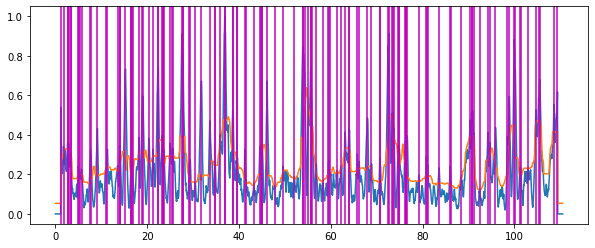

In [ ]:
fsize = 92
offset = 0.25

threshold = scipy.ndimage.filters.median_filter(novelty_curve, size = fsize) + novelty_curve.mean() * offset
peaks = []

for i in range(1, novelty_curve.shape[0] - 1):
    # is it a peak?
    if novelty_curve[i - 1] < novelty_curve[i] and novelty_curve[i] > novelty_curve[i + 1]:
        # is it above the threshold?
        if novelty_curve[i] > threshold[i]:
            peaks.append(i)
            
peaks = np.array(peaks)*(duration/len(novelty_curve))
            
plt.figure(1, figsize=(10, 4))
plt.plot(time_axis, novelty_curve)
plt.plot(time_axis, threshold)
for peak in peaks:
    plt.axvline(peak, color="m")
plt.show()

In [ ]:
true_positives = [10, 20, 30, 40, 50, 54] 
margin = 0.5                                # in sec; 200 ms 

# SCORING COMPUTATION

# En este caso, se establece un modelo de evaluación en el que solo se contemplan True positive and False positive, ya que el caso de True negative no aplica.
tp_score = 0
fp_score = 0

for peak in peaks:
  for tp in true_positives:
    if tp - margin <= peak <= tp + margin:
      tp_score += 1
    else:
      fp_score += 1

score = tp_score / (tp_score + fp_score)    #Precision is calculated
score


0.0103359173126615

## **5.   RESULTS SUMMARY**


Text(0.5, 0.98, 'FFT size: 4096          Nº Mel Filters: 194          Nº Mel Coefficients: 10          Threshold filter size: 92          Kernel Size: 0.9046666026630431 seconds')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


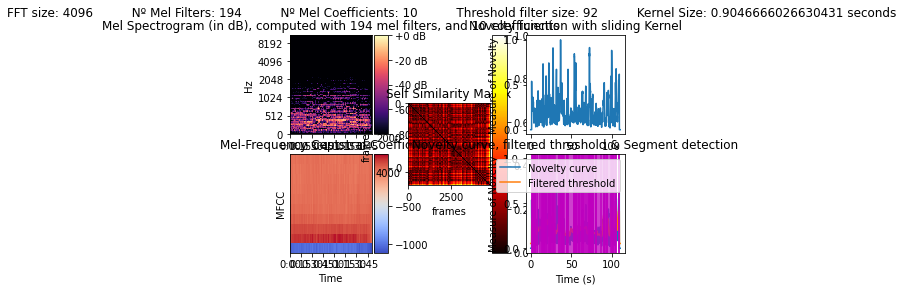

In [ ]:
fig = plt.figure(2, constrained_layout = True)
gs = fig.add_gridspec(2, 3)
fig.tight_layout()
#fig.subplots_adjust(hspace=.5)

# subplot(m,n,p) divide la figura actual en una cuadrícula de m por n y crea 
# ejes en la posición que especifica p. ordenando las posiciones de subgráfica 
# por fila. La primera subgráfica es la primera columna de la primera fila, la 
# segunda subgráfica es la segunda columna de la primera fila y así sucesivamente.

p1 = plt.subplot(gs[0, 0])
p11 = librosa.display.specshow(db_S, sr = sample_rate, x_axis = 'time', y_axis = 'mel', ax = p1)
p1.set_title("Mel Spectrogram (in dB), computed with {0} mel filters".format(num_mel_filt) + ", and {0} coefficients".format(num_mel_coefficients))
cbar1 = fig.colorbar(p11, format = "%+2.f dB")

p2 = plt.subplot(gs[1, 0])
p22 = librosa.display.specshow(mfcc, x_axis = 'time')
p2.set_title("Mel-Frequency Ceptstral Coefficients")
p2.set_ylabel("MFCC")
cbar2 = fig.colorbar(p22)



p3 = plt.subplot(gs[:, 1])
p33 = plt.imshow(SSM, cmap='hot', interpolation='nearest')
p3.set_title("Self Similarity Matrix")
p3.set_xlabel("frames")
p3.set_ylabel("frames")
cbar3 = fig.colorbar(p33)



p4 = plt.subplot(gs[0, 2])
p44 = plt.plot(time_axis, novelty_curve)
p4.set_title('Novelty function with sliding Kernel')
p4.set_xlabel('Time (s)')
p4.set_ylabel('Measure of Novelty')

p5 = plt.subplot(gs[1, 2])
p5.plot(time_axis, novelty_curve, label = 'Novelty curve')
p5.plot(time_axis, threshold, label = 'Filtered threshold')
for peak in peaks:
    p5.axvline(peak, color="m")
p5.set_title('Novelty curve, filtered threshold & Segment detection')
p5.set_xlabel('Time (s)')
p5.set_ylabel('Measure of Novelty')
p5.legend()

fig.suptitle("FFT size: {0}          ".format(FFT_size) + 
             "Nº Mel Filters: {0}          ".format(num_mel_filt) + 
        "Nº Mel Coefficients: {0}          ".format(num_mel_coefficients) + 
        "Threshold filter size: {0}          ".format(fsize) + 
        "Kernel Size: {0} seconds".format(gauss_size /duration))
